# Scenario: user selects an L-R pair and cell types, with interacting regions and p-values as outputs

# 1. Prepare data

In [17]:
import stlearn as st
import pandas as pd
import random
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_2
data = st.Read10X("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1")
data.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# 2 Preprocessing

### 2.1. filter, normalize, scale & PCA

In [18]:
st.pp.filter_genes(data,min_cells=0.00*data.n_vars)
st.pp.normalize_total(data)
data.obsm['normalized'] = pd.DataFrame(data.X.toarray(), index=data.obs_names, columns=data.var_names)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

### 2.2. add morphology information

In [19]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract feature: 100%|████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Adjusting data: 100%|█████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In [27]:
data.obsm['normalized'] = pd.DataFrame(data.X, index=data.obs_names, columns=data.var_names)

# 3. Cell-cell interaction analysis

### 3.1 Cell type diversity based on transferred labels

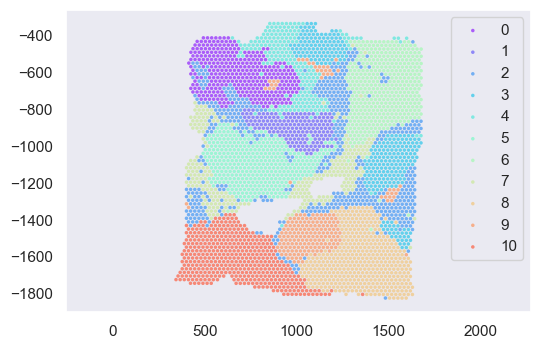

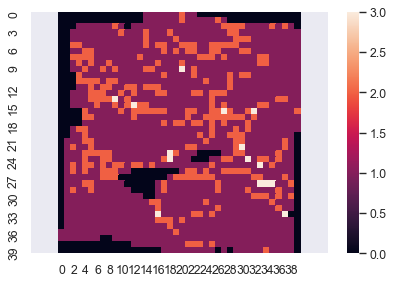

In [30]:
st.tl.cci.het.count(data, use_clustering='louvain', num_row=40, num_col=40)
st.pl.het_plot(data, use_cluster='louvain', use_het='het', dpi=100, name='het_louvain', output='.')

### 3.2 Clustering based on Ligand-Receptor (L-R) co-expression

#### Read in user input LR pair

In [31]:
data.uns["lr"] = ['CXCL12_CXCR4']
#data.uns["lr"] = ['ZMYM4_NFIA']

#### cluster spatial spots based on the proportion of known ligand-receptor co-expression in the neighbouring spots

In [32]:
st.tl.cci.base.lr(adata=data, use_data='normalized')

AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'predictions', 'louvain', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'louvain', 'tmp_color', 'het', 'lr', 'lr_neighbours_louvain_max'
    obsm: 'spatial', 'filtered_counts', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### plot the CCI clustering results and highlight the largest expressed cluster

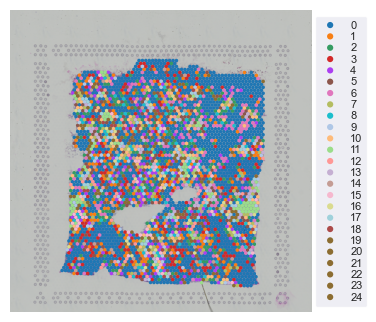

In [33]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain", dpi=100)

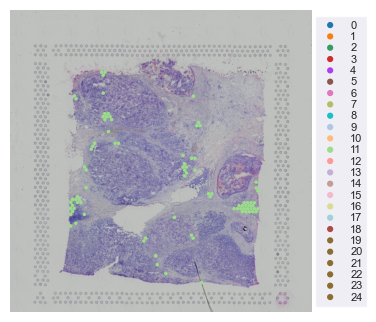

In [34]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain",list_cluster=[data.uns['lr_neighbours_louvain_max']], dpi=100, name='lr_neighbours_louvain', output='.')

#### Merge results from cci clustering and cell type heterogeneity

In [35]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
st.tl.cci.merge(data, use_lr='lr_neighbours_louvain_max', use_het='het')

AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'predictions', 'louvain', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'louvain', 'tmp_color', 'het', 'lr', 'lr_neighbours_louvain_max', 'merged'
    obsm: 'spatial', 'filtered_counts', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

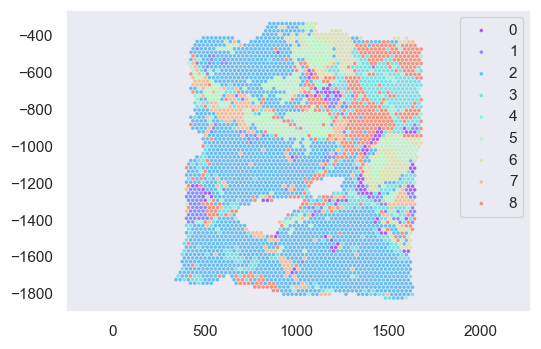

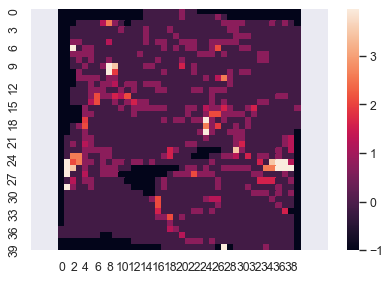

In [36]:
st.pl.het_plot(data, use_cluster='predictions', use_het='merged', dpi=100, name='final', output='.')

### Caution! The next step could take several hours depending on the permutation parameters.

In [37]:
st.tl.cci.permutation(data, n_pairs=1000)

AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'predictions', 'louvain', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'louvain', 'tmp_color', 'het', 'lr', 'lr_neighbours_louvain_max', 'merged', 'pvalue', 'permutation', 'merged_pvalues', 'merged_sign'
    obsm: 'spatial', 'filtered_counts', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [1]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#sns.set(color_codes=True)
#sns.clustermap(data.uns['permutation'])
#plt.show()

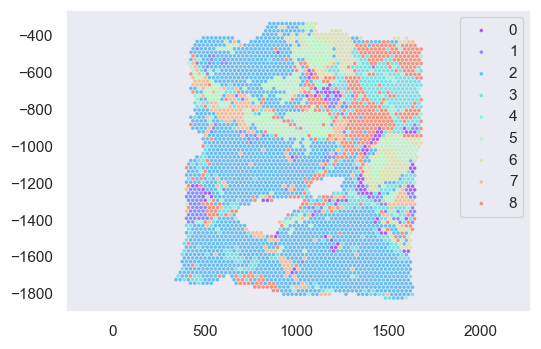

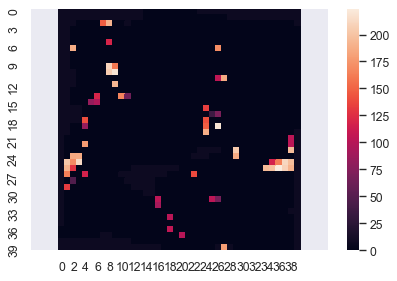

In [39]:
# plot the -log10(pvalue) from permutation test on each spot
st.pl.het_plot(data, use_cluster='predictions', use_het='merged_pvalues', dpi=100, name='permutation', output='.')

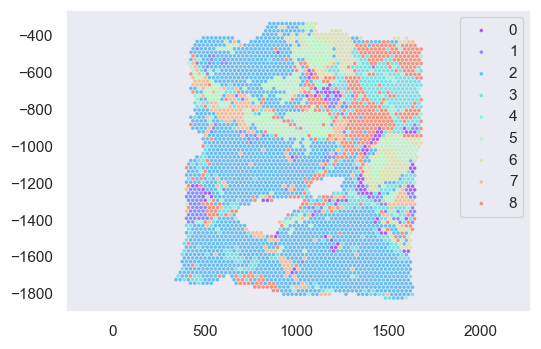

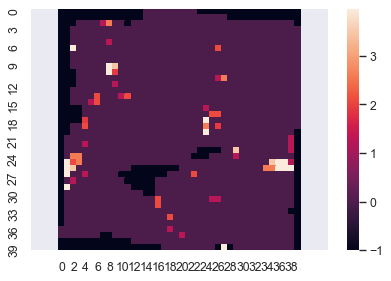

In [40]:
st.pl.het_plot(data, use_cluster='predictions', use_het='merged_sign', dpi=100, name='final', output='.')